In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv('C:\\Users\\HP\\Downloads\\dynamic_pricing.csv')

In [3]:
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [4]:
df.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


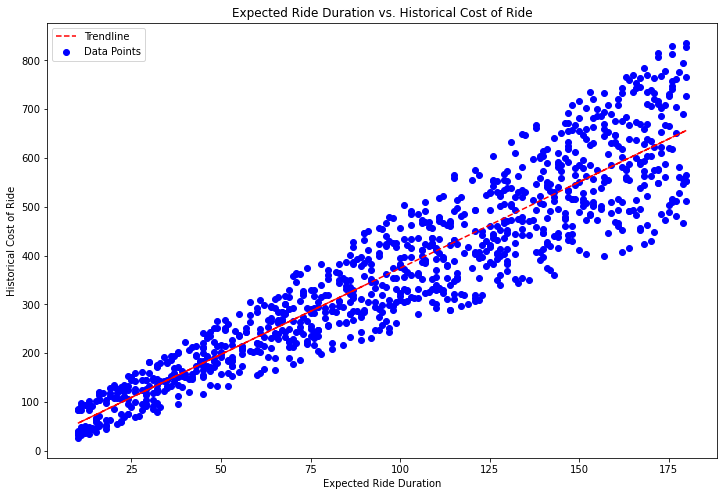

In [20]:
plt.figure(figsize=(12,8))
fig = plt.scatter(df['Expected_Ride_Duration'], df['Historical_Cost_of_Ride'], color='blue', label='Data Points')

x = df['Expected_Ride_Duration']
y = df['Historical_Cost_of_Ride']


plt.plot(x, trendline(x), color='red', linestyle='--', label='Trendline')

plt.xlabel('Expected Ride Duration')
plt.ylabel('Historical Cost of Ride')
plt.title('Expected Ride Duration vs. Historical Cost of Ride')
plt.legend()

plt.show()

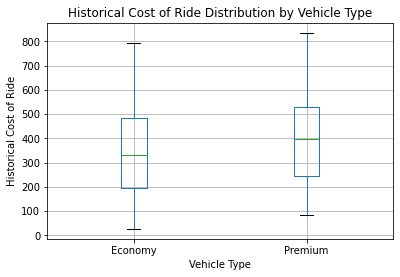

In [26]:
df.boxplot(column='Historical_Cost_of_Ride', by='Vehicle_Type')
plt.title('Historical Cost of Ride Distribution by Vehicle Type')
plt.suptitle('')  
plt.xlabel('Vehicle Type')
plt.ylabel('Historical Cost of Ride')

plt.show()

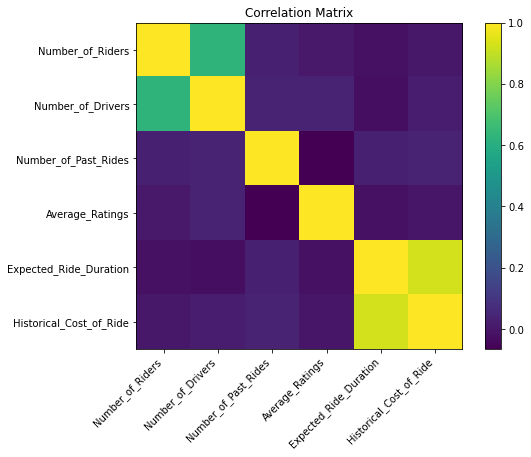

In [28]:
corr_matrix = df.corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='viridis', interpolation='none')
plt.colorbar()

# Add ticks and labels
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)

# Add title
plt.title('Correlation Matrix')

# Show the plot
plt.show()


In [29]:


high_demand_percentile = 75
low_demand_percentile = 25

df['demand_multiplier'] = np.where(df['Number_of_Riders'] > np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                    df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                    df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], low_demand_percentile))

high_supply_percentile = 75
low_supply_percentile = 25

df['supply_multiplier'] = np.where(df['Number_of_Drivers'] > np.percentile(df['Number_of_Drivers'], low_supply_percentile),
                                    np.percentile(df['Number_of_Drivers'], high_supply_percentile) / df['Number_of_Drivers'],
                                    np.percentile(df['Number_of_Drivers'], low_supply_percentile) / df['Number_of_Drivers'])

demand_threshold_high = 1.2  
demand_threshold_low = 0.8 
supply_threshold_high = 0.8  
supply_threshold_low = 1.2 
df['adjusted_ride_cost'] = df['Historical_Cost_of_Ride'] * (
    np.maximum(df['demand_multiplier'], demand_threshold_low) *
    np.maximum(df['supply_multiplier'], supply_threshold_high)
)


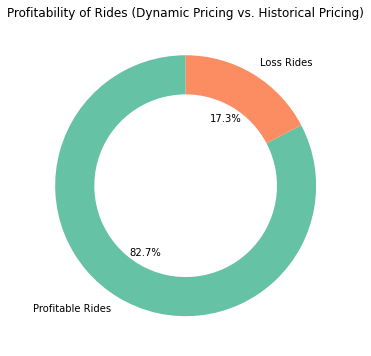

In [30]:
df['profit_percentage'] = ((df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) / df['Historical_Cost_of_Ride']) * 100

profitable_rides = df[df['profit_percentage'] > 0]

loss_rides = df[df['profit_percentage'] < 0]
import matplotlib.pyplot as plt

profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]


fig, ax = plt.subplots(figsize=(8, 6))

wedges, texts, autotexts = ax.pie(
    values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66c2a5', '#fc8d62'],  
    wedgeprops=dict(width=0.3)  
)

plt.title('Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')

plt.show()


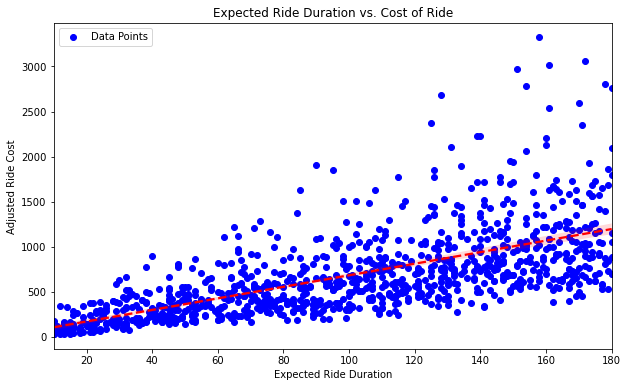

In [32]:
import seaborn as sns
plt.figure(figsize=(10, 6))
plt.scatter(df['Expected_Ride_Duration'], df['adjusted_ride_cost'], color='blue', label='Data Points')


sns.regplot(x='Expected_Ride_Duration', y='adjusted_ride_cost', data=df, scatter=False, color='red', line_kws={'linestyle': '--'})

plt.xlabel('Expected Ride Duration')
plt.ylabel('Adjusted Ride Cost')
plt.title('Expected Ride Duration vs. Cost of Ride')

plt.legend()

plt.show()

In [33]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def data_preprocessing_pipeline(df):
    numeric_features = df.select_dtypes(include=['float', 'int']).columns
    categorical_features = df.select_dtypes(include=['object']).columns

    df[numeric_features] = df[numeric_features].fillna(df[numeric_features].mean())

    for feature in numeric_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        df[feature] = np.where((df[feature] < lower_bound) | (df[feature] > upper_bound),
                              df[feature].mean(), df[feature])

    df[categorical_features] = df[categorical_features].fillna(df[categorical_features].mode().iloc[0])

    return df


In [34]:
df["Vehicle_Type"] = df["Vehicle_Type"].map({"Premium": 1, 
                                           "Economy": 0})

In [35]:
from sklearn.model_selection import train_test_split
x = np.array(df[["Number_of_Riders", "Number_of_Drivers", "Vehicle_Type", "Expected_Ride_Duration"]])
y = np.array(df[["adjusted_ride_cost"]])

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

y_train = y_train.ravel()
y_test = y_test.ravel()

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

In [38]:
model.score(x_test,y_test)

0.8671509748215398

In [40]:
def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {
        "Premium": 1,
        "Economy": 0
    }
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric
  
def predict_price(number_of_riders, number_of_drivers, vehicle_type, Expected_Ride_Duration):
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError("Invalid vehicle type")
    
    input_data = np.array([[number_of_riders, number_of_drivers, vehicle_type_numeric, Expected_Ride_Duration]])
    predicted_price = model.predict(input_data)
    return predicted_price

user_number_of_riders = 500
user_number_of_drivers = 200
user_vehicle_type = "Economy"
Expected_Ride_Duration = 18
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, user_vehicle_type, Expected_Ride_Duration)
print("Predicted price:", predicted_price)

Predicted price: [55.3205738]


In [41]:
import joblib

In [42]:
joblib.dump(model,'model.joblib')

['model.joblib']